# **Implementation of a Three Hidden Layer Neural Network for Multi-Class Classification**

**Import Required Libraries**

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# set a random seed so we get the same results every time
np.random.seed(0)

**Generate the 5 Class Synthetic Dataset**

X shape: (1000, 2)
y shape: (1000,)
Classes: [0 1 2 3 4]


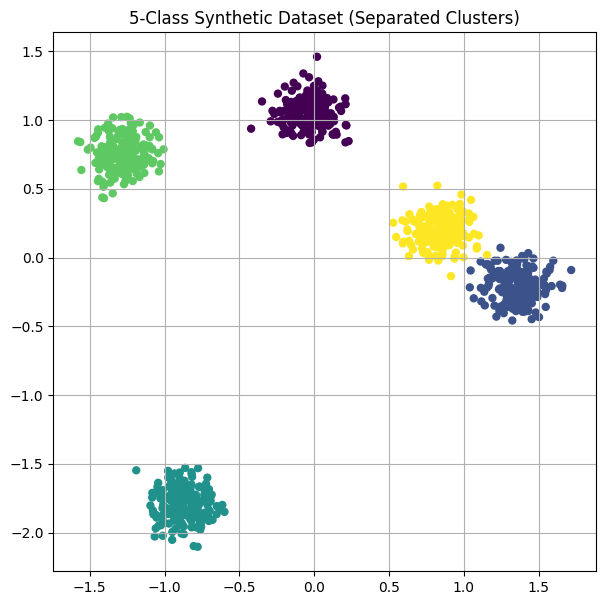

In [17]:
from sklearn.datasets import make_blobs

X, y = make_blobs(
    n_samples=1000,
    centers=5,
    n_features=2,
    cluster_std=0.6,
    random_state=42
)

# standardize the input data
X = (X - X.mean(axis=0)) / X.std(axis=0)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Classes:", np.unique(y))

# scatter plot to visualize the 5 clusters
plt.figure(figsize=(7,7))
plt.scatter(X[:,0], X[:,1], c=y, s=25)
plt.title("5-Class Synthetic Dataset (Separated Clusters)")
plt.grid(True)
plt.show()

**Apply One-Hot Encoding and Split Data**

In [4]:
# turn numeric labels (0–4) into one-hot encoded vectors
def one_hot(y, num_classes=5):
    oh = np.zeros((y.shape[0], num_classes))
    oh[np.arange(y.shape[0]), y] = 1
    return oh

# convert y into one-hot format
Y = one_hot(y, 5)

# split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test, y_train_cls, y_test_cls = train_test_split(
    X, Y, y, test_size=0.3, random_state=42, stratify=y
)

print("Train shapes:", X_train.shape, Y_train.shape)
print("Test shapes:", X_test.shape, Y_test.shape)


Train shapes: (700, 10) (700, 5)
Test shapes: (300, 10) (300, 5)


**Define the Three Hidden Layer Neural Network**

In [7]:
# a neural network with three hidden layers
class NeuralNetwork:
    def __init__(self, input_dim, h1, h2, h3, output_dim, lr=0.001):
        self.lr = lr

        # initialize weights using He initialization
        self.W1 = np.random.randn(input_dim, h1) * np.sqrt(2 / input_dim)
        self.b1 = np.zeros((1, h1))

        self.W2 = np.random.randn(h1, h2) * np.sqrt(2 / h1)
        self.b2 = np.zeros((1, h2))

        self.W3 = np.random.randn(h2, h3) * np.sqrt(2 / h2)
        self.b3 = np.zeros((1, h3))

        self.W4 = np.random.randn(h3, output_dim) * np.sqrt(2 / h3)
        self.b4 = np.zeros((1, output_dim))

    # basic ReLU activation function
    def relu(self, x):
        return np.maximum(0, x)

    # derivative of ReLU for backprop
    def relu_derivative(self, x):
        return (x > 0).astype(float)

    # softmax for multi-class output
    def softmax(self, z):
        # subtract max value to avoid overflow
        z_shift = z - np.max(z, axis=1, keepdims=True)
        exp_vals = np.exp(z_shift)
        return exp_vals / np.sum(exp_vals, axis=1, keepdims=True)

    # forward pass through all 4 layers
    def forward(self, X):
        self.X = X

        # layer 1
        self.z1 = X @ self.W1 + self.b1
        self.a1 = self.relu(self.z1)

        # layer 2
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = self.relu(self.z2)

        # layer 3
        self.z3 = self.a2 @ self.W3 + self.b3
        self.a3 = self.relu(self.z3)

        # output layer
        self.z4 = self.a3 @ self.W4 + self.b4
        self.y_hat = self.softmax(self.z4)

        return self.y_hat

    # cross-entropy loss function
    def loss(self, Y_true):
        eps = 1e-10
        return -np.mean(np.sum(Y_true * np.log(self.y_hat + eps), axis=1))

    # backward pass to compute gradients
    def backward(self, Y):
        m = Y.shape[0]

        # gradient at output layer
        dz4 = (self.y_hat - Y) / m
        dW4 = self.a3.T @ dz4
        db4 = np.sum(dz4, axis=0, keepdims=True)

        # gradients for third hidden layer
        dz3 = (dz4 @ self.W4.T) * self.relu_derivative(self.z3)
        dW3 = self.a2.T @ dz3
        db3 = np.sum(dz3, axis=0, keepdims=True)

        # gradients for second hidden layer
        dz2 = (dz3 @ self.W3.T) * self.relu_derivative(self.z2)
        dW2 = self.a1.T @ dz2
        db2 = np.sum(dz2, axis=0, keepdims=True)

        # gradients for first hidden layer
        dz1 = (dz2 @ self.W2.T) * self.relu_derivative(self.z1)
        dW1 = self.X.T @ dz1
        db1 = np.sum(dz1, axis=0, keepdims=True)

        # update all weights and biases
        self.W4 -= self.lr * dW4; self.b4 -= self.lr * db4
        self.W3 -= self.lr * dW3; self.b3 -= self.lr * db3
        self.W2 -= self.lr * dW2; self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1; self.b1 -= self.lr * db1

    # one training step
    def train_step(self, X, Y):
        self.forward(X)
        loss = self.loss(Y)
        self.backward(Y)
        return loss

    # return predicted class index
    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)


**Train the Neural Network Model**

Epoch 250 - Loss: 1.5326
Epoch 500 - Loss: 1.4138
Epoch 750 - Loss: 1.3187
Epoch 1000 - Loss: 1.2337
Epoch 1250 - Loss: 1.1456
Epoch 1500 - Loss: 1.0570
Epoch 1750 - Loss: 0.9743
Epoch 2000 - Loss: 0.9002


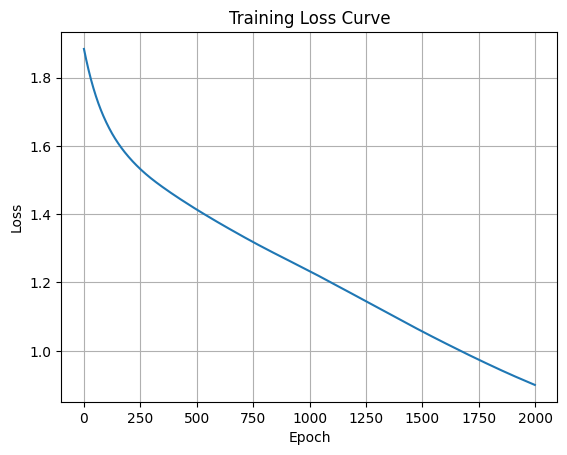

In [8]:
# create the neural network with layer sizes
nn = NeuralNetwork(
    input_dim=10,
    h1=64,
    h2=32,
    h3=16,
    output_dim=5,
    lr=0.001
)

epochs = 2000
loss_list = []

# train the model for the given number of epochs
for ep in range(epochs):
    L = nn.train_step(X_train, Y_train)
    loss_list.append(L)

    # print loss occasionally
    if (ep + 1) % 250 == 0:
        print(f"Epoch {ep + 1} - Loss: {L:.4f}")

# show loss over time
plt.plot(loss_list)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


**Evaluate the Model on Test Data**

In [9]:
# get predictions for the test set
y_pred = nn.predict(X_test)

# print precision, recall, F1-score for each class
print("\nClassification Report:")
print(classification_report(y_test_cls, y_pred))

# compute confusion matrix
cm = confusion_matrix(y_test_cls, y_pred)
print("\nConfusion Matrix:\n", cm)



Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.68      0.64        60
           1       0.73      0.68      0.71        60
           2       0.84      0.63      0.72        60
           3       0.68      0.67      0.67        60
           4       0.58      0.70      0.64        60

    accuracy                           0.67       300
   macro avg       0.69      0.67      0.68       300
weighted avg       0.69      0.67      0.68       300


Confusion Matrix:
 [[41  1  1  9  8]
 [ 6 41  1  2 10]
 [ 4  6 38  7  5]
 [ 4  4  5 40  7]
 [13  4  0  1 42]]


**Plot the Confusion Matrix**

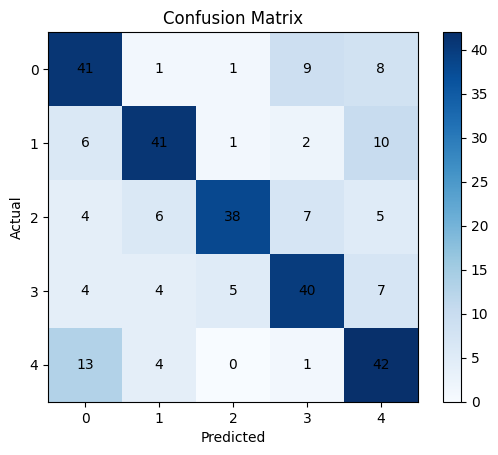

In [10]:
# plot the confusion matrix
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()

# display value inside each cell
for i in range(5):
    for j in range(5):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**ROC Curves for 5 Class Neural Network Model**

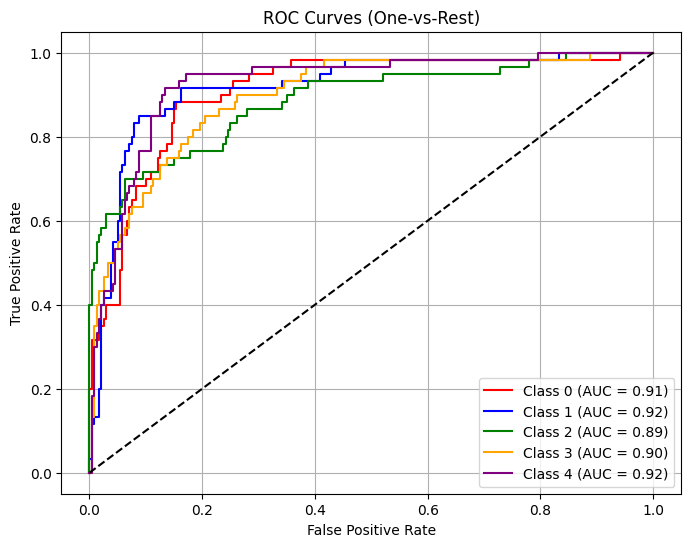

In [20]:
from sklearn.metrics import roc_curve, auc

# predicted probabilities
y_proba = nn.forward(X_test)

fpr = {}
tpr = {}
roc_auc = {}

# calculate ROC for each class
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plot ROC curves
plt.figure(figsize=(8,6))
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i in range(5):
    plt.plot(fpr[i], tpr[i], color=colors[i],
             label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curves (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()